# Predicting NBA Game Outcomes Project

## Author: Si Bao

## Course Project, UC Irvine, Math 10, S24

## I would like to post my notebook on the course’s website. Yes

# Table of Contents
1. [Introduction](#Introduction)
2. [Data Preparation](#Data-Preparation)
3. [Helper Function](#Helper-Function)
4. [Linear Models](#Linear-Models)
    1. [Linear Regression](#Linear-Regression)
    2. [Ridge Regression](#Ridge-Regression)
    3. [Lasso Regression](#Lasso-Regression)
5. [Logistic Regression](#Logistic-Regression)
6. [K-Nearest Neighbor Regression](#K-Nearest-Neighbor-Regression)
7. [Decision Trees](#Decision-Trees)
8. [Support Vector Machines](#Support-Vector-Machines)
9. [Conclusion](#Conclusion)

# Introduction

**The National Basketball Association (NBA) is a professional basketball league in North America composed of 30 teams (29 in the United States and 1 in Canada). It is one of the major professional sports leagues in the United States and Canada and is considered the premier professional basketball league in the world.
In my project, I will utilize the game data from 2014 to 2021 to predict the points and winning rate of each team**

# Data Preparation

**The section imports all necessary tools, generate all the necessary data, and drop data with missing values**

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import r2_score, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
games = pd.read_csv('games.csv')
teams = pd.read_csv('teams.csv')

In [3]:
Team = teams['NICKNAME'].tolist()
Team_abb = teams['ABBREVIATION'].tolist()
ID = teams['TEAM_ID'].tolist()

The following two cells describe the teams and the corresponding team ID

In [4]:
Team

['Hawks',
 'Celtics',
 'Pelicans',
 'Bulls',
 'Mavericks',
 'Nuggets',
 'Rockets',
 'Clippers',
 'Lakers',
 'Heat',
 'Bucks',
 'Timberwolves',
 'Nets',
 'Knicks',
 'Magic',
 'Pacers',
 '76ers',
 'Suns',
 'Trail Blazers',
 'Kings',
 'Spurs',
 'Thunder',
 'Raptors',
 'Jazz',
 'Grizzlies',
 'Wizards',
 'Pistons',
 'Hornets',
 'Cavaliers',
 'Warriors']

In [5]:
ID

[1610612737,
 1610612738,
 1610612740,
 1610612741,
 1610612742,
 1610612743,
 1610612745,
 1610612746,
 1610612747,
 1610612748,
 1610612749,
 1610612750,
 1610612751,
 1610612752,
 1610612753,
 1610612754,
 1610612755,
 1610612756,
 1610612757,
 1610612758,
 1610612759,
 1610612760,
 1610612761,
 1610612762,
 1610612763,
 1610612764,
 1610612765,
 1610612766,
 1610612739,
 1610612744]

In [6]:
# This section drops the rows with missing values
games_clean = games.dropna()

In [7]:
# This section generates the data of each team in each season

Team_data = [] # This list will store the performance of each team from 2014 to 2021
for i in range(0, len(Team)):
    temp_team = games_clean[(games_clean['TEAM_ID_home'] == ID[i]) | (games_clean['TEAM_ID_away'] == ID[i])]
    temp_team_away = temp_team.loc[temp_team.TEAM_ID_home == ID[i],['SEASON', 'PTS_home', 'FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home']]
    temp_team_away.rename(columns = {'PTS_home': 'PTS', 'FG_PCT_home': 'FG_PCT', 'FT_PCT_home': 'FT_PCT', 'FG3_PCT_home': 'FG3_PCT', 'AST_home': 'AST', 'REB_home': 'REB'}, inplace = True)
    temp_team_home = temp_team.loc[temp_team.TEAM_ID_away == ID[i], ['SEASON', 'PTS_away', 'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away']]
    temp_team_home.rename(columns = {'PTS_away': 'PTS', 'FG_PCT_away': 'FG_PCT', 'FT_PCT_away': 'FT_PCT', 'FG3_PCT_away': 'FG3_PCT', 'AST_away': 'AST', 'REB_away': 'REB'}, inplace = True)
    com_team = pd.concat([temp_team_away, temp_team_home], ignore_index = True)
    Team_data.append(com_team)

**Feature Explanation**:

PTS_home: Points by home team

FG_PCT_home: ratio of field goals to field goals attempts by home team

FT_PCT_home: ratio of free throws to free throws attempts by home team

FG3_PCT_home: ratio of three-point field goals to three-point field goals attempts by home team

AST_home: number of assists made home team

REB_home: number of rebounds for home team

PTS_away: Points by away team

FG_PCT_away: ratio of field goals to field goals attempts by away team

FT_PCT_away: ratio of free throws to free throws attempts by away team

FG3_PCT_away: ratio of three-point field goals to three-point field goals attempts by away team

AST_away: number of assists made away team

REB_away: number of rebounds for away team

In [8]:
# This section creates a new column called "PTS_DIFF_home_away",
# which is determined by home team points minus away team points
new_games_clean = games_clean.copy()
new_games_clean['PTS_DIFF_home_away'] = new_games_clean.apply(lambda row: row['PTS_home'] - row['PTS_away'], axis = 1)
new_games_clean.head()

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS,PTS_DIFF_home_away
0,2022-03-12,22101005,Final,1610612748,1610612750,2021,1610612748,104.0,0.398,0.760,...,53.0,1610612750,113.0,0.422,0.875,0.357,21.0,46.0,0,-9.0
1,2022-03-12,22101006,Final,1610612741,1610612739,2021,1610612741,101.0,0.443,0.933,...,46.0,1610612739,91.0,0.419,0.824,0.208,19.0,40.0,1,10.0
2,2022-03-12,22101007,Final,1610612759,1610612754,2021,1610612759,108.0,0.412,0.813,...,52.0,1610612754,119.0,0.489,1.000,0.389,23.0,47.0,0,-11.0
3,2022-03-12,22101008,Final,1610612744,1610612749,2021,1610612744,122.0,0.484,0.933,...,55.0,1610612749,109.0,0.413,0.696,0.386,27.0,39.0,1,13.0
4,2022-03-12,22101009,Final,1610612743,1610612761,2021,1610612743,115.0,0.551,0.750,...,39.0,1610612761,127.0,0.471,0.760,0.387,28.0,50.0,0,-12.0


# Helper Function

**This section defines several functions that will later be used for approximation and plotting in order to avoid repeated and long contents**

The **'prediction_with_Linear_Models'** function is used for the **'Linear Models'** section.
It takes the input of home team name, away team name, and
one of the three linear model names:
**Linear Regression, Ridge Regression, and Lasso Regression**

In [9]:
def prediction_with_Linear_Models(home, away, model_name):
    home_index = Team.index(home)
    away_index = Team.index(away)
    home_id = ID[home_index]
    away_id = ID[away_index]
    
    # set the models for home and away team according to the model_name input
    if model_name == 'Linear Regression':
        model_home = LinearRegression()
        model_away = LinearRegression()
    elif model_name == 'Ridge Regression':
        model_home = Ridge()
        model_away = Ridge()
    elif model_name == 'Lasso Regression':
        model_home = Lasso()
        model_away = Lasso()
    else:
        return 'This model is not included'
    
    # set the features(X) and target(y) for approximation
    home_features = ['FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home']
    home_target = ['PTS_home']
    away_features = ['FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away']
    away_target = ['PTS_away']
    
    # find the correspoding dataset containing both home team and away team from the cleaned big dataset
    temp_team = games_clean[(games_clean['TEAM_ID_home'] == home_id) & (games_clean['TEAM_ID_away'] == away_id)]
    
    X_home = temp_team[home_features]
    y_home = temp_team[home_target]
    
    X_away = temp_team[away_features]
    y_away = temp_team[away_target]
    
    # fit the model
    model_home.fit(X_home, y_home)
    model_away.fit(X_away, y_away)
    
    # predict the points that home and away team will get using the fitted model
    pred_home = model_home.predict(X_home)
    pred_away = model_away.predict(X_away)
    
    # duplicate the dataset so that the original one will not be modified
    temp_team_copy = temp_team.copy()
    
    # create a new column of predicted points for both teams
    temp_team_copy['PTS_home_pred'] = pred_home
    temp_team_copy['PTS_home_away'] = pred_away
    
    # create a new column of predicted home win using the predicted points column above
    temp_team_copy['HOME_TEAM_WINS_pred'] = temp_team_copy.apply(lambda row: row['PTS_home_pred'] > row['PTS_home_away'], axis=1)
    temp_team_copy['HOME_TEAM_WINS_pred'] = temp_team_copy['HOME_TEAM_WINS_pred'].astype(int)
    
    # compare the actual and predicts home win and create a new column to record the True/False results
    temp_team_copy['CORRECT_pred'] = temp_team_copy.apply(lambda row: row['HOME_TEAM_WINS'] == row['HOME_TEAM_WINS_pred'], axis=1)
    temp_team_copy['CORRECT_pred'] = temp_team_copy['CORRECT_pred'].astype(int)
    
    # find the accuracy
    acc = accuracy_score(temp_team_copy['HOME_TEAM_WINS'], temp_team_copy['HOME_TEAM_WINS_pred'])
    
    # return a dataset for reporting and graphing
    return {
        'mean_HOME_TEAM_WINS_pred': np.mean(temp_team_copy['HOME_TEAM_WINS_pred']),
        'accuracy': acc,
        'actual_home_points': y_home,
        'predicted_home_points': pred_home,
        'actual_away_points': y_away,
        'predicted_away_points': pred_away,
        'home_coefficients': model_home.coef_,
        'home_intercept': model_away.intercept_,
        'away_coefficients': model_home.coef_,
        'away_intercept': model_away.intercept_
    }

The **'prediction_with_Other_Models'** function is used for the **'Logistic Regression', 'Decision Trees', and 'Support Vector Machines'** section.
It takes the input of home team name, away team name, and
one of the three model names:
**Logistic Regression, Decision Trees, and Support Vector Machines**

In [10]:
def prediction_with_Other_Models(home, away, model_name):
    accuracy = []
    home_index = Team.index(home)
    away_index = Team.index(away)
    home_id = ID[home_index]
    away_id = ID[away_index]
    
    # find the correspoding dataset containing both home team and away team from the cleaned big dataset
    temp = games_clean[(games_clean['TEAM_ID_home'] == home_id) & (games_clean['TEAM_ID_away'] == away_id)]
    temp_dummy = pd.get_dummies(temp, columns = ['TEAM_ID_home', 'TEAM_ID_away'])
    
    features = ['FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home', 'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away']
    target = ['HOME_TEAM_WINS']
    
    # set the models for home and away team according to the model_name input
    if model_name == 'Logistic Regression':
        model = LogisticRegression(max_iter = 20000, solver = 'lbfgs')
        X = temp[features].values
        y = temp[target].values.ravel()
    elif model_name == 'Decision Trees':
        model = DecisionTreeClassifier(random_state = 42)
        X = temp[features].values
        y = temp[target].values.ravel()
    elif model_name == 'Support Vector Machines':
        model = SVC(random_state = 42)
        X = temp_dummy.drop(columns = ['GAME_DATE_EST', 'GAME_ID', 'GAME_STATUS_TEXT', 'HOME_TEAM_ID', 'SEASON', 'PTS_home', 'VISITOR_TEAM_ID', 'PTS_away', 'HOME_TEAM_WINS'])
        y = temp_dummy['HOME_TEAM_WINS']
    else:
        return 'This model is not included'
    
    # split data for training and tesing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
    
    # fit the data
    model.fit(X_train, y_train)    
    y_pred_test = model.predict(X_test)
    y_pred = model.predict(X)
    
    accuracy = accuracy_score(y_test, y_pred_test)
    
    # return dataset for reporting and graphing
    return {
        'accuracy': accuracy,
        'mean_prediction': np.mean(y_pred),
        'actual_values': y,
        'predicted_values': y_pred,
    }

The **'plot_score'** function is used for plotting the relationship betweenthe predicted and actual points for home and away team

In [11]:
def plot_score(home, away, model_name):
    # get the required data for plotting
    results = prediction_with_Linear_Models(home, away, model_name)
    
    # store the predicted and actual points for home and away team
    actual_home_points = results['actual_home_points'].to_numpy().flatten()
    predicted_home_points = results['predicted_home_points'].flatten()
    actual_away_points = results['actual_away_points'].to_numpy().flatten()
    predicted_away_points = results['predicted_away_points'].flatten()

    # plot the graph for home team
    plt.subplot(1, 2, 1)
    plt.scatter(actual_home_points, predicted_home_points, color = 'blue', label = 'Home Team')
    plt.plot([actual_home_points.min(), actual_home_points.max()],
             [actual_home_points.min(), actual_home_points.max()],
             color = 'black', linestyle = '--', label = 'Perfect Prediction')
    plt.xlabel('Actual Home Points')
    plt.ylabel('Predicted Home Points')
    plt.title('Home Team')
    plt.legend()
    
    # plot the graph for away team
    plt.subplot(1, 2, 2)
    plt.scatter(actual_away_points, predicted_away_points, color = 'red', label = 'Away Team')
    plt.plot([actual_away_points.min(), actual_away_points.max()],
             [actual_away_points.min(), actual_away_points.max()],
             color = 'black', linestyle = '--', label = 'Perfect Prediction')
    plt.xlabel('Actual Away Points')
    plt.ylabel('Predicted Away Points')
    plt.title('Away Team')
    plt.legend()
    
    plt.suptitle('Actual vs Predicted Points for Home and Away Teams')
    plt.tight_layout(rect = [0, 0.03, 1, 0.95])
    plt.show()

The **'plot_win'** function is used for plotting the relationship between actual and predicted home wins

In [12]:
def plot_win(results):
    plt.figure(figsize = (5, 3))
    plt.hexbin(results['actual_values'], results['predicted_values'], gridsize = 30, cmap = 'Blues', mincnt = 1, edgecolors = 'grey')
    plt.colorbar(label = 'Count')
    plt.xlabel('Actual Home Win (0 or 1)')
    plt.ylabel('Predicted Home Win (0 or 1)')
    plt.title('Actual Home Win vs. Predicted Home Win')
    plt.grid(True)
    plt.show()

# Linear Models

## Linear Regression

In [14]:
# This section predicts the points each team will have depending on the following features:
# FG_PCT, PT_PCT, FG3_PCT, AST, REB
# Model used: Linear Regression

reg = LinearRegression()
kf = KFold(n_splits = 5, shuffle = True, random_state = 1)
scores = []

features = ['FG_PCT', 'FT_PCT', 'FG3_PCT', 'AST','REB']
target = ['PTS']

k = 1
a = 0
for i in range(0, len(Team_data)):
    for train_index, test_index in kf.split(Team_data[i]): # Test the prediction using 5-fold cross-validation
        temp = Team_data[i]
        X_train, X_test = temp[features].iloc[train_index], temp[features].iloc[test_index]
        y_train, y_test = temp[target].iloc[train_index], temp[target].iloc[test_index]
        
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        score = r2_score(y_test, y_pred)
        scores.append(score)
        
print(np.mean(score))

0.7116344958573725


This average number show that linear regression has an overall high accuracy in predicting total points

In [15]:
# This section gives an exmaple of predicting the winning possibility of
# the home team Dallas Mavericks against the away team Boston Celtics using Linear Regression

results = prediction_with_Linear_Models('Mavericks', 'Celtics', 'Linear Regression')
ave = results['mean_HOME_TEAM_WINS_pred']
acc = results['accuracy']

print(f'The predicted possibility that home team Mavericks wins the game against away team Celtics is {ave}')
print(f'The accuracy is {acc}')

The predicted possibility that home team Mavericks wins the game against away team Celtics is 0.7894736842105263
The accuracy is 0.8947368421052632


This example shows that linear regression is quite accurate in predicting the game result between Dallas Mavericks and Boston Celtics

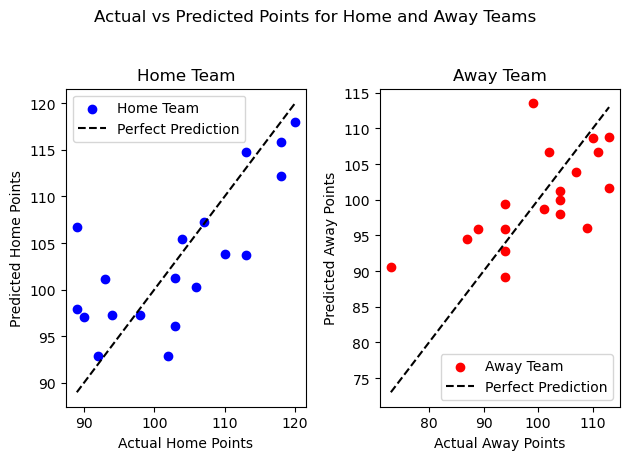

In [16]:
# This section visualizes the approximation by Linear Regression

home = 'Mavericks'
away = 'Celtics'

plot_score(home, away, 'Linear Regression')

The two graphs show that for both teams, the predicted and actual points are pretty close for over 70 percent of the samples

## Ridge Regression

In [17]:
# This section predicts the points each team will have depending on the following features:
# FG_PCT, PT_PCT, FG3_PCT, AST, REB
# Model used: Ridge Regression

ridge = Ridge(alpha = 0.1)
kf = KFold(n_splits = 5, shuffle = True, random_state = 1)
scores = []

features = ['FG_PCT', 'FT_PCT', 'FG3_PCT', 'AST','REB']
target = ['PTS']

k = 1
a = 0
for i in range(0, len(Team_data)):
    for train_index, test_index in kf.split(Team_data[i]): # Test the prediction using 5-fold cross-validation
        temp = Team_data[i]
        X_train, X_test = temp[features].iloc[train_index], temp[features].iloc[test_index]
        y_train, y_test = temp[target].iloc[train_index], temp[target].iloc[test_index]
        
        ridge.fit(X_train, y_train)
        y_pred = ridge.predict(X_test)
        score = r2_score(y_test, y_pred)
        scores.append(score)
        
print(np.mean(score))

0.7099268435047021


This average number show that ridge regression has an overall high accuracy in predicting total points

In [18]:
# This section gives an exmaple of predicting the winning possibility of
# the home team Dallas Mavericks against the away team Boston Celtics using Ridge Regression

results = prediction_with_Linear_Models('Mavericks', 'Celtics', 'Ridge Regression')
ave = results['mean_HOME_TEAM_WINS_pred']
acc = results['accuracy']

print(f'The predicted possibility that home team Mavericks wins the game against away team Celtics is {ave}')
print(f'The accuracy is {acc}')

The predicted possibility that home team Mavericks wins the game against away team Celtics is 0.631578947368421
The accuracy is 0.631578947368421


This example shows that ridge regression is relatively less accurate in predicting the game result between Dallas Mavericks and Boston Celtics

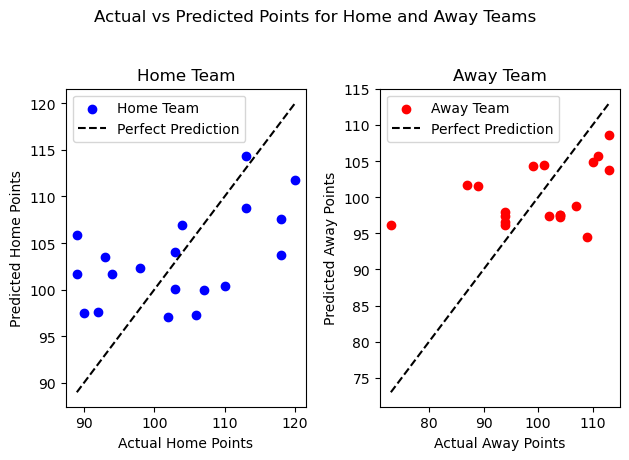

In [19]:
# This section visualizes the approximation by Ridge Regression

home = 'Mavericks'
away = 'Celtics'

plot_score(home, away, 'Ridge Regression')

The two graphs show that for both teams, the predicted and actual points by ridge regression are more scattered than the graph of linear regression

## Lasso Regression

In [20]:
# This section predicts the points each team will have depending on the following features:
# FG_PCT, PT_PCT, FG3_PCT, AST, REB
# Model used: Lasso Regression

lasso = Lasso(alpha = 0.1)
kf = KFold(n_splits = 5, shuffle = True, random_state = 1)
scores = []

features = ['FG_PCT', 'FT_PCT', 'FG3_PCT', 'AST','REB']
target = ['PTS']

k = 1
a = 0
for i in range(0, len(Team_data)):
    for train_index, test_index in kf.split(Team_data[i]): # Test the prediction using 5-fold cross-validation
        temp = Team_data[i]
        X_train, X_test = temp[features].iloc[train_index], temp[features].iloc[test_index]
        y_train, y_test = temp[target].iloc[train_index], temp[target].iloc[test_index]
        
        lasso.fit(X_train, y_train)
        y_pred = lasso.predict(X_test)
        score = r2_score(y_test, y_pred)
        scores.append(score)
        
print(np.mean(score))

0.6612318106475936


This number shows that lasso regression has an above-average accuracy

In [21]:
# This section gives an exmaple of predicting the winning possibility of
# the home team Dallas Mavericks against the away team Boston Celtics using Lasso Regression

results = prediction_with_Linear_Models('Mavericks', 'Celtics', 'Lasso Regression')
ave = results['mean_HOME_TEAM_WINS_pred']
acc = results['accuracy']

print(f'The predicted possibility that home team Mavericks wins the game against away team Celtics is {ave}')
print(f'The accuracy is {acc}')

The predicted possibility that home team Mavericks wins the game against away team Celtics is 0.631578947368421
The accuracy is 0.631578947368421


This example shows that the accuracy is basically the same as the overall accuracy

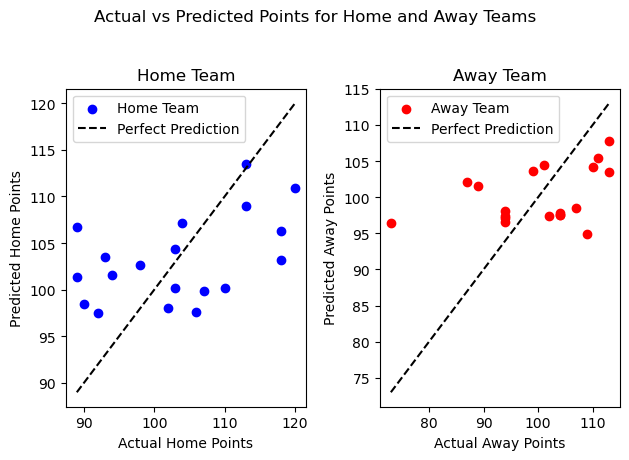

In [22]:
# This section visualizes the approximation by Lasso Regression

home = 'Mavericks'
away = 'Celtics'

plot_score(home, away, 'Lasso Regression')

These two graph are similar to those of ridge regression, with minor differences.

**Summarizing the three regression tools, we can conclude that linear regression has the best approximation accuracy in predicting the game and points results**

# Logistic Regression

In [23]:
# This section generates the overall accuracy by feeding the model with the data of all 30 teams

overall_accuracy = []
for i in range(0, len(Team)):
    temp_team = deepcopy(Team)
    temp_team.remove(Team[i])
    for j in range(0, len(temp_team)):
        results = prediction_with_Other_Models(Team[i], temp_team[j], 'Logistic Regression')
        overall_accuracy.append(results['accuracy'])
        
av_acc = np.mean(overall_accuracy)
print(f'The overall accuracy of predicting the winning rate of each team is {av_acc}')

The overall accuracy of predicting the winning rate of each team is 0.6978113802657413


In [24]:
# This section gives an example of predicting the result between two specific games.
# As an example, we want to predict the result between
# Boston celtics and Dallas Mavericks using Logistic Regression

results = prediction_with_Other_Models('Mavericks', 'Celtics', 'Logistic Regression')
possi = results['mean_prediction']
acc = results['accuracy']

print(f'The predicted winning rate of home team Celtics against away team Mavericks is {possi}')
print(f'The overall accuracy is {acc}')

The predicted winning rate of home team Celtics against away team Mavericks is 0.5789473684210527
The overall accuracy is 0.0


It turns out that logistic regression is not useful in this example, since the accuracu is 0

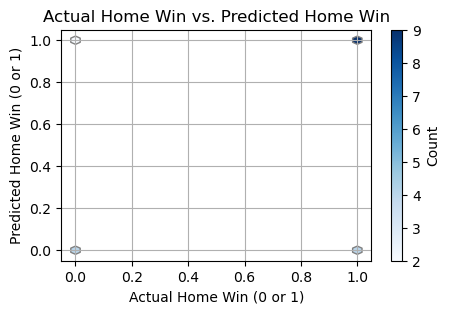

In [25]:
# This section visualizes the approximation by Logistic Regression

home = 'Mavericks'
away = 'Celtics'
results = prediction_with_Other_Models(home, away, 'Logistic Regression')

plot_win(results)

# K-Nearest Neighbor Regression

In [28]:
# This function is individually set in this section because we need to find the best k first
# I have to change the input 'n' in a for loop,
# so I can't combine it with the 'prediction_with_Other_Models' function

def prediction_with_KNN_home(home, away, n):
    accuracy = []
    home_index = Team.index(home)
    away_index = Team.index(away)
    home_id = ID[home_index]
    away_id = ID[away_index]
    
    temp = games_clean[(games_clean['TEAM_ID_home'] == home_id) & (games_clean['TEAM_ID_away'] == away_id)]
    temp_dummy = pd.get_dummies(temp, columns = ['TEAM_ID_home', 'TEAM_ID_away'])
    
    X = temp_dummy.drop(columns = ['GAME_DATE_EST', 'GAME_ID', 'GAME_STATUS_TEXT', 'HOME_TEAM_ID', 'SEASON', 'PTS_home', 'VISITOR_TEAM_ID', 'PTS_away', 'HOME_TEAM_WINS'])
    y = temp_dummy['HOME_TEAM_WINS']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    knn = KNeighborsClassifier(n_neighbors = n)
    knn.fit(X_train, y_train)
    
    y_pred_test = knn.predict(X_test)
    y_pred = knn.predict(X)
    acc = accuracy_score(y_test, y_pred_test)
    
    return acc, np.mean(y_pred)

In [29]:
# This section tests the accuracy of KNN model using k-value from 1 to 12 

overall_accuracy = []
ave_acc = []
for k in range(1, 13):
    for i in range(0, len(Team)):
        temp_team = deepcopy(Team)
        temp_team.remove(Team[i])
        
        for j in range(0, len(temp_team)):
            acc, ave_pred = prediction_with_KNN_home(Team[i], temp_team[j], k)
            overall_accuracy.append(acc)
            
    ave_acc.append(np.mean(overall_accuracy))
    
ave_acc

[0.6341139639415501,
 0.6213082591099833,
 0.6350885980771038,
 0.635928071768589,
 0.640380678708265,
 0.6408117159553941,
 0.6428693515023564,
 0.6433556469871125,
 0.6436807594278858,
 0.6434954470816538,
 0.6431105841215559,
 0.642111453893063]

In [30]:
# This part calculates the best value of k for approximation
max_acc = max(ave_acc)
best_k = ave_acc.index(max_acc) + 1
print(f'The best k is {best_k}')
print(f'The overall accuracy of predicting the winning rate of each team is {max_acc}')

The best k is 9
The overall accuracy of predicting the winning rate of each team is 0.6436807594278858


KNN model returns an average accuracy, and the best best k in this circumstance is 9

In [32]:
# This section gives an example of predicting the result between two specific games.
# As an example, we want to predict the result between
# Dallas Mavericks and Boston Celtics using KNN with the best k value we obtained from the cell above

acc, possi = prediction_with_KNN_home('Mavericks', 'Celtics', best_k)
print(f'The predicted winning rate of home team Dallas Mavericks against away team Boston Celtics is {possi}')
print(f'The overall accuracy is {acc}')

The predicted winning rate of home team Dallas Mavericks against away team Boston Celtics is 0.7894736842105263
The overall accuracy is 0.75


KNN has a pretty good accuracy in this exmaple

# Decision Trees

In [33]:
# This section generates the overall accuracy by feeding the model with the data of all 30 teams

overall_accuracy = []
for i in range(0, len(Team)):
    temp_team = deepcopy(Team)
    temp_team.remove(Team[i])
    for j in range(0, len(temp_team)):
        results = prediction_with_Other_Models(Team[i], temp_team[j], 'Decision Trees')
        overall_accuracy.append(results['accuracy'])
        
av_acc = np.mean(overall_accuracy)
print(f'The overall accuracy of predicting the winning rate of each team is {av_acc}')

The overall accuracy of predicting the winning rate of each team is 0.6718327363231015


The Decision Trees model returns an average accuracy

In [35]:
# This section gives an example of predicting the result between two specific games.
# As an example, we want to predict the result between
# Dallas Mavericks and Minnesota Timberwolves using Decision Trees

results = prediction_with_Other_Models('Mavericks', 'Celtics', 'Decision Trees')

possi = results['mean_prediction']
acc = results['accuracy']

print(f'The predicted winning rate of home team Dallas Maverick against away team Minnesota Timberwolves is {possi}')
print(f'The overall accuracy is {acc}')

The predicted winning rate of home team Dallas Maverick against away team Minnesota Timberwolves is 0.631578947368421
The overall accuracy is 0.5


The Decision Trees model does not give a vey good accuracy in this example

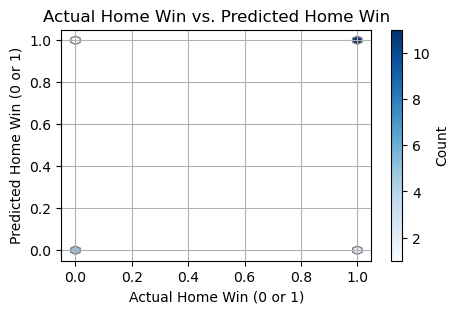

In [36]:
# This section visualizes the approximation of home wins using Decision Trees

home = 'Mavericks'
away = 'Celtics'
results = prediction_with_Other_Models(home, away, 'Decision Trees')

plot_win(results)

# Support Vector Machines

In [37]:
# This section generates the overall accuracy by feeding the model with the data of all 30 teams

overall_accuracy = []
for i in range(0, len(Team)):
    temp_team = deepcopy(Team)
    temp_team.remove(Team[i])
    for j in range(0, len(temp_team)):
        results = prediction_with_Other_Models(Team[i], temp_team[j], 'Support Vector Machines')
        overall_accuracy.append(results['accuracy'])
        
av_acc = np.mean(overall_accuracy)
print(f'The overall accuracy of predicting the winning rate of each team is {av_acc}')

The overall accuracy of predicting the winning rate of each team is 0.585768289257133


SVM gives a relatively lowest accuracy, which implies that SVM may not be suitable for prediction of NBA game results

In [38]:
# This section gives an example of predicting the result between two specific games.
# As an example, we want to predict the result between
# Dallas Mavericks and Minnesota Timberwolves using Support Vector Machine

results = prediction_with_Other_Models('Mavericks', 'Celtics', 'Support Vector Machines')

possi = results['mean_prediction']
acc = results['accuracy']

print(f'The predicted winning rate of home team Dallas Mavericks against away team Minnesota Timberwolves is {possi}')
print(f'The overall accuracy is {acc}')

The predicted winning rate of home team Dallas Mavericks against away team Minnesota Timberwolves is 1.0
The overall accuracy is 0.6666666666666666


SVM has an average performance in this example

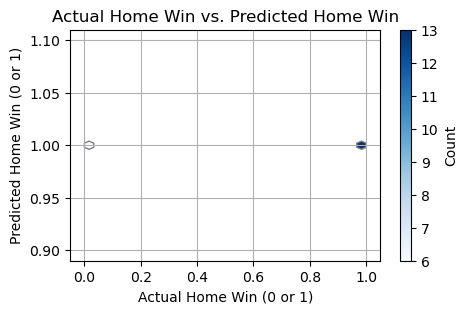

In [41]:
# This section visualizes the approximation of home wins using Support Vector Machines

home = 'Mavericks'
away = 'Celtics'
results = prediction_with_Other_Models(home, away, 'Support Vector Machines')

plot_win(results)

# Conclusion

**In this project, I try to predict the NBA game outcomes using 7 Machine Learning tools. Three of the tools are used for predicting total points of home and away team, and four of them are used for predicting home team wins. Linear Regression gives the best accuracy score: 71.16%, while Support Vector Machines yields the worst: 58.58%. Nonetheless, the outcomes emphasize that Machine Learning is promising in the field of basketball game predictions.**